In [2]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from scipy.special import logit
from DS_models_stat import stat_orig_cats
from DS_detector import rematch_cat
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from DS_models_stat import cut_cat

In [3]:
def m500_z_graph(cat_name, det_name, q_rat=0.1, big_pix=None, text='', max_pred_val=None):
    df = pd.read_csv(cat_name)
    df = df[df['status'] != 'fn']
    df.index = np.arange(len(df))
    
    true_cats = {'PSZ2(z)' : pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'),
                'MCXC' : pd.read_csv('/home/rt2122/Data/clusters/mcxcwp.csv'),
                'ACT' : pd.read_csv('/home/rt2122/Data/clusters/actwp.csv')
                #'MCXC' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/MCXC.csv'),
                #'ACT' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/ACT.csv')
                }
    
    if not (big_pix is None):
        df = cut_cat(df, big_pix=big_pix)
        for tr_cat in true_cats:
            true_cats[tr_cat] = cut_cat(true_cats[tr_cat], big_pix=big_pix)
        
    true_sc = {key : SkyCoord(ra=np.array(true_cats[key]['RA']) * u.degree, 
                              dec=np.array(true_cats[key]['DEC']) * u.degree, frame='icrs') for key in true_cats}
    
    q = df[df['catalog'] == 'planck_z']['max_pred'].quantile(q_rat)
    if not (max_pred_val is None):
        q = max_pred_val
    sc = SkyCoord(ra=np.array(df['RA']) * u.degree, dec=np.array(df['DEC']) * u.degree, frame='icrs')
    
    for name in true_cats:
        idx, d2d, _ = true_sc[name].match_to_catalog_sky(sc)
        true_cats[name]['max_pred'] = 0
        true_cats[name]['max_pred'] = np.array(df['max_pred'][idx])
        matched = d2d.degree < (400 / 3600)
        true_cats[name]['matched'] = matched
    
    fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
    fig.tight_layout()
    for i, (st, en) in enumerate([[q, 1], [0.1, 1]]):
        for name, c in zip(true_cats, ['b', 'r', 'c']):
            cur_cat = true_cats[name]
            cur_cat = cur_cat[cur_cat['matched']]
            match_max_pred = np.logical_and(st <= cur_cat['max_pred'], cur_cat['max_pred'] <= en)
            s = ax[i].scatter(cur_cat[match_max_pred]['z'], cur_cat[match_max_pred]['M500'], c=c, alpha=0.2)
            s.set_label('{} max_pred > {:.2g}'.format(name, st))
            plt.yscale('log')
    
    for name, c in zip(true_cats, ['b', 'r', 'c']):
        cur_cat = true_cats[name]
        cur_cat = cur_cat[np.logical_not(cur_cat['matched'])]
        s = ax[2].scatter(cur_cat['z'], cur_cat['M500'], c=c, alpha=0.2)
        s.set_label('{} unmatched'.format(name))
        plt.yscale('log')
    
    ax[0].set_ylabel('M500')
    for i in range(3):
        ax[i].set_ylim(10**-1, 20)
        ax[i].set_xlabel('z')
        ax[i].grid(which='minor', axis='both', linestyle='--')
        ax[i].grid(which='major', axis='both', linestyle='--')
        ax[i].legend()
    ax[1].set_title(text)


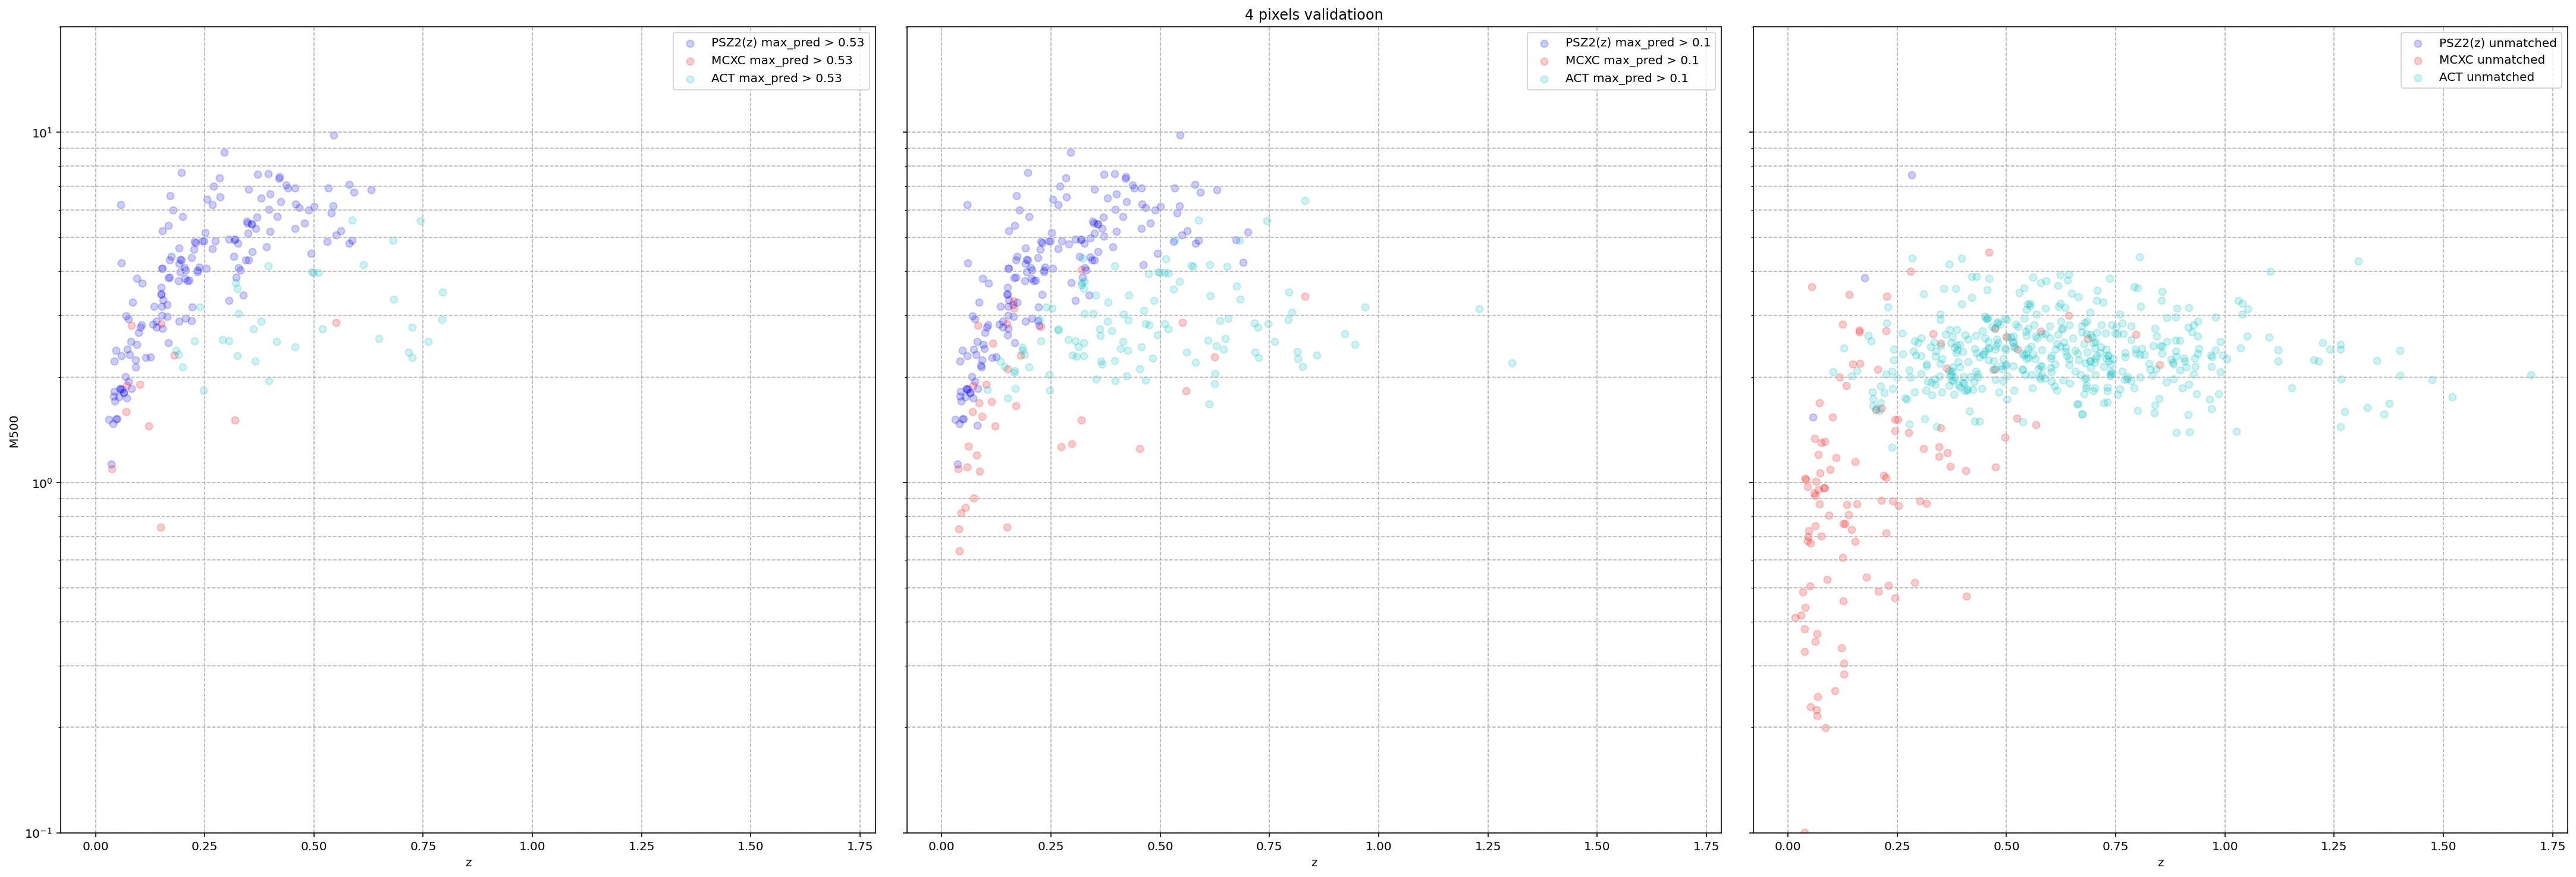

In [8]:
m500_z_graph('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', 'pz_all_found34', big_pix=west_val+east_val,
            text='4 pixels validatioon')

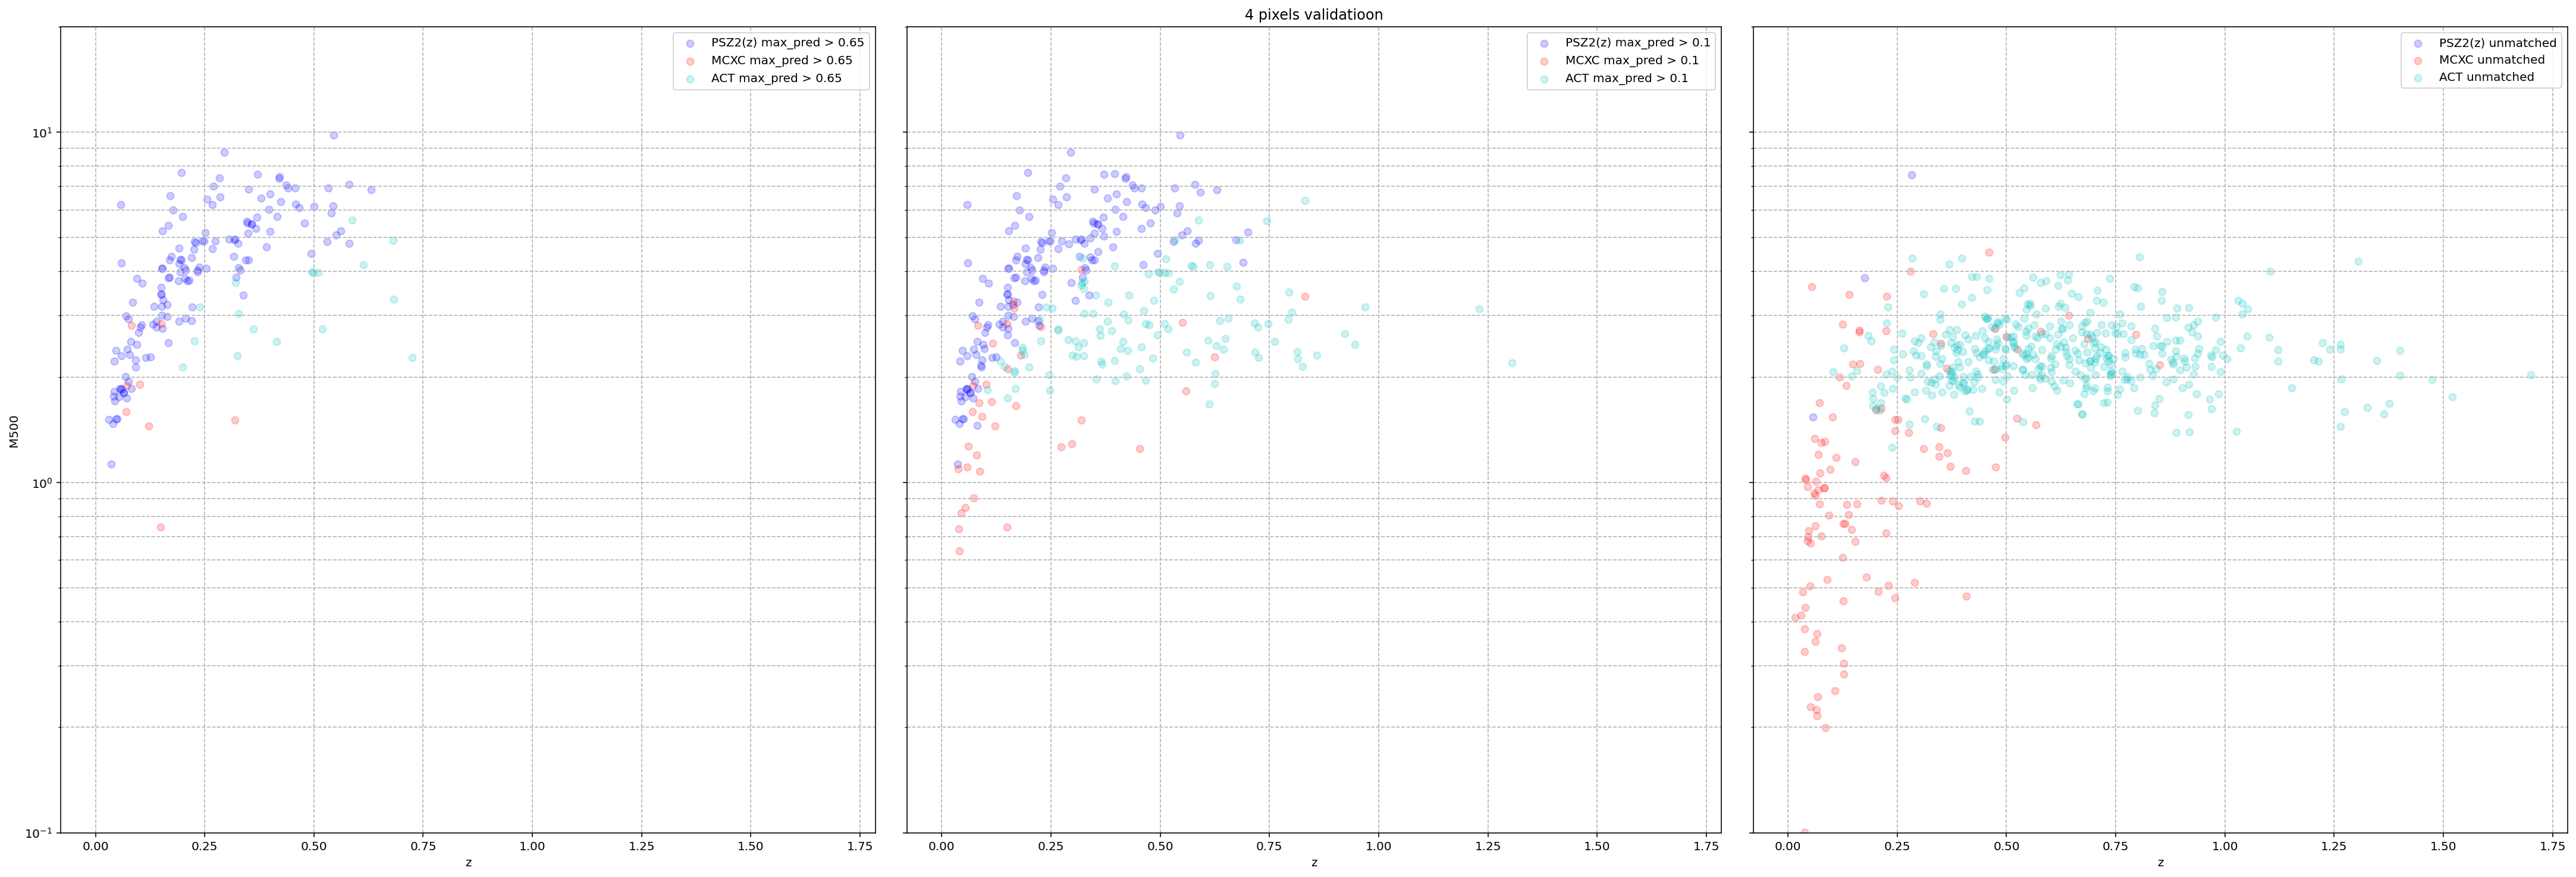

In [3]:
m500_z_graph('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', 'pz_all_found34', big_pix=west_val+east_val,
            text='4 pixels validatioon', max_pred_val=0.65)

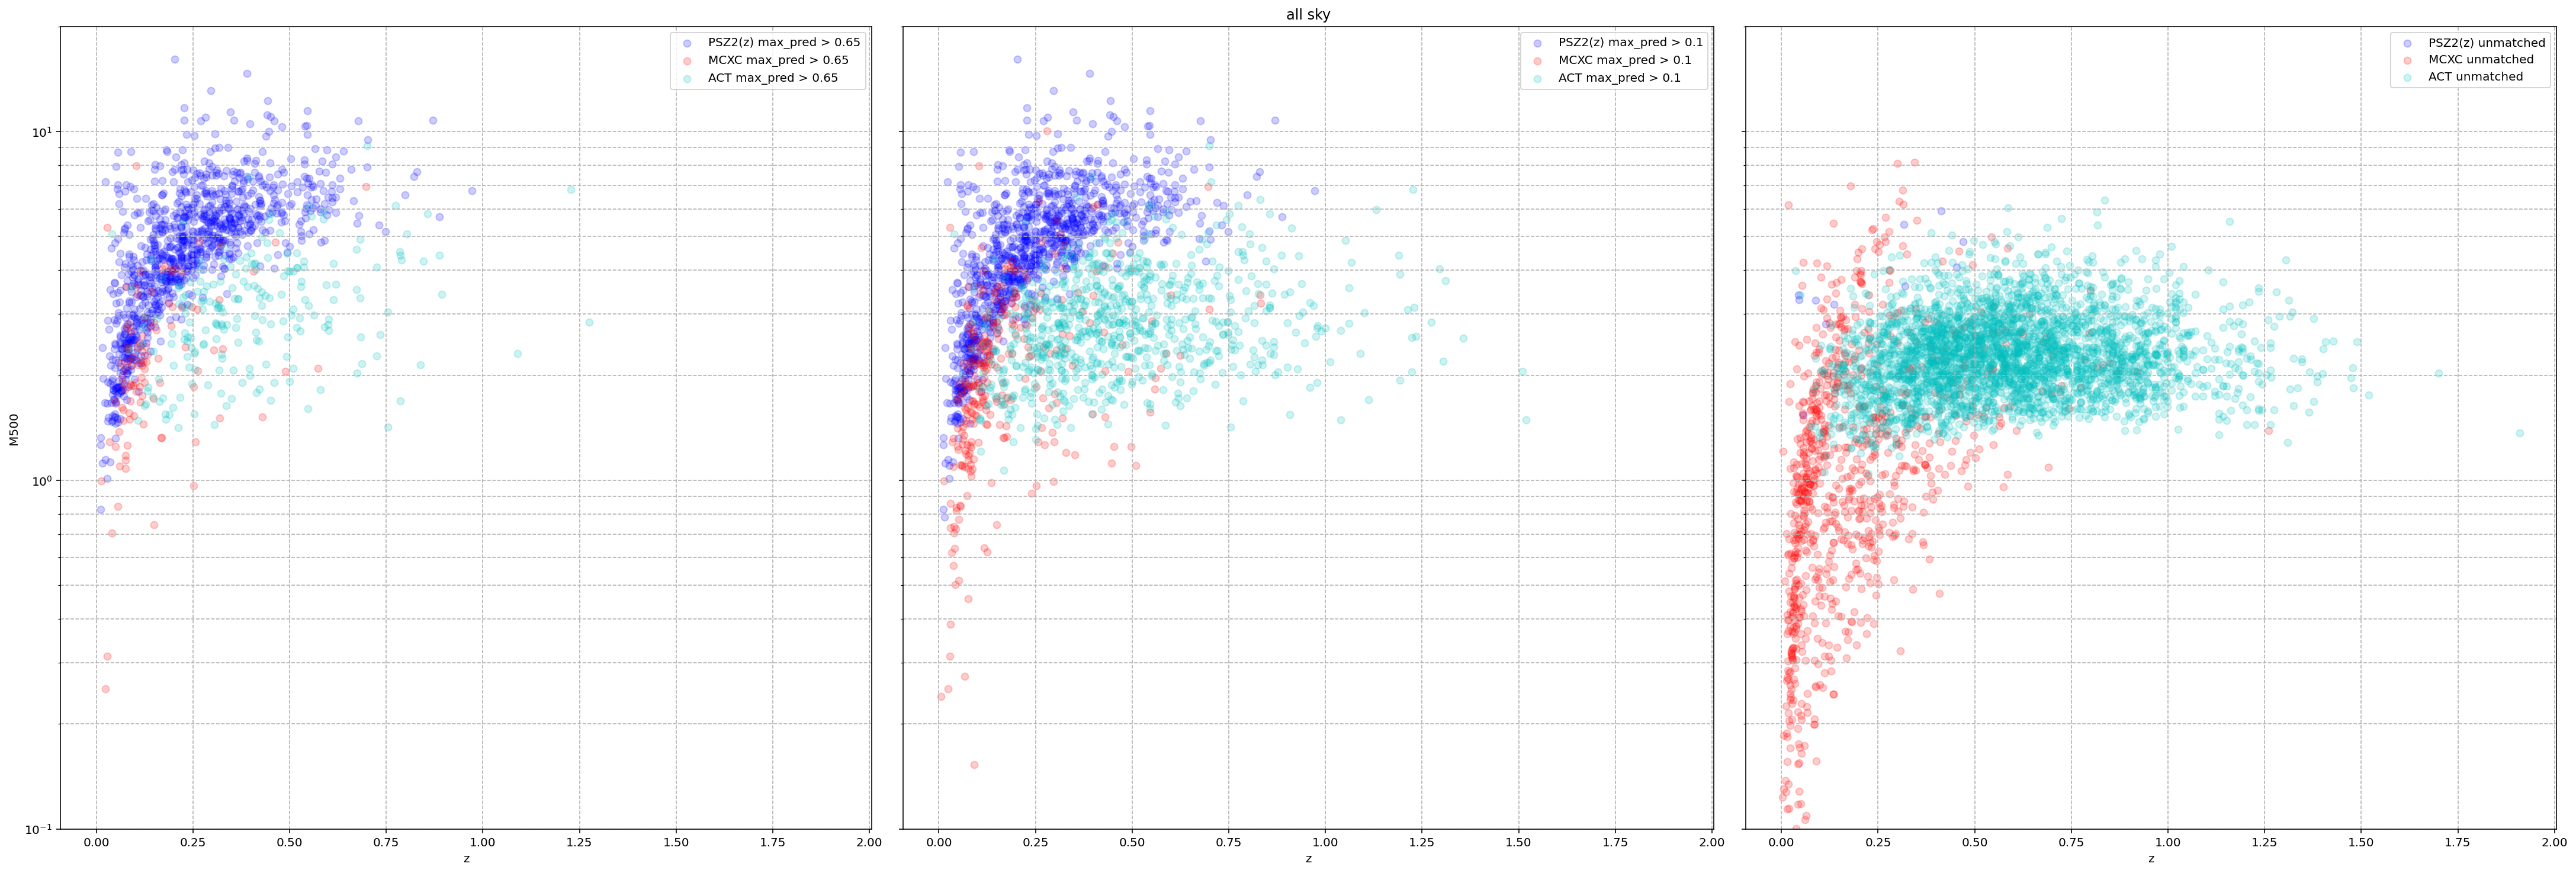

In [4]:
m500_z_graph('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', 'pz_all_found34', big_pix=list(range(48)),
            text='all sky', max_pred_val=0.65)

In [6]:
all_found = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
brcat = pd.read_csv('/home/rt2122/Data/SRGz/brcat.csv')

In [7]:
all_found_sc = SkyCoord(ra=np.array(all_found['RA'])*u.degree, dec=np.array(all_found['DEC'])*u.degree, frame='icrs')
brcat_sc = SkyCoord(ra=np.array(brcat['RA'])*u.degree, dec=np.array(brcat['DEC'])*u.degree, frame='icrs')

In [8]:
brcat = brcat.rename({'max_pred' : 's/n'}, axis='columns')

In [9]:
idx, d2d, _ = all_found_sc.match_to_catalog_sky(brcat_sc)
matched = d2d.degree <= 400/3600
all_found['s/n'] = 0
all_found['s/n'].iloc[matched] = np.array(brcat['s/n'][idx[matched]])
inter = all_found[matched]
inter.index = np.arange(len(inter))

all_found_unique = all_found[np.logical_not(matched)]
idx, d2d, _ = brcat_sc.match_to_catalog_sky(all_found_sc)
matched = d2d.degree <= 400/3600
brcat_unique = brcat[np.logical_not(matched)]

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
print(len(all_found), len(all_found_unique) + len(inter))
len(brcat), len(brcat_unique) + len(inter)

23352 23352


(13772, 13473)

In [12]:
all_found_unique.to_csv('/home/rt2122/Data/inter_cats/all_found_unique.csv', index=False)
brcat_unique.to_csv('/home/rt2122/Data/inter_cats/brcat_unique.csv', index=False)
inter.to_csv('/home/rt2122/Data/inter_cats/inter.csv', index=False)

In [2]:
inter = pd.read_csv('/home/rt2122/Data/inter_cats/inter.csv')
inter['max_pred'] = inter['s/n']
inter.to_csv('/home/rt2122/Data/inter_cats/inter_sn.csv', index=False)

In [2]:
brcat = pd.read_csv('/home/rt2122/Data/inter_cats/brcat_unique.csv')
brcat = brcat.rename({'s/n' : 'max_pred'}, axis='columns')
brcat.to_csv('/home/rt2122/Data/inter_cats/brcat_unique.csv', index=False)

In [5]:
def m500_z_simple(ax, cat_name, det_name, big_pix=None, text='', alpha=1, dict_cut={}, ax_unmatched=None):
    df = pd.read_csv(cat_name)
    
    true_cats = {'PSZ2(z)' : pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'),
                #'MCXC' : pd.read_csv('/home/rt2122/Data/clusters/mcxcwp.csv'),
                #'ACT' : pd.read_csv('/home/rt2122/Data/clusters/actwp.csv')
                'MCXC' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/MCXC.csv'),
                'ACT' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/ACT.csv'),
                }
    
    if not (big_pix is None):
        df = cut_cat(df, big_pix=big_pix, dict_cut=dict_cut)
        for tr_cat in true_cats:
            true_cats[tr_cat] = cut_cat(true_cats[tr_cat], big_pix=big_pix, dict_cut=dict_cut)
        
    true_sc = {key : SkyCoord(ra=np.array(true_cats[key]['RA']) * u.degree, 
                              dec=np.array(true_cats[key]['DEC']) * u.degree, frame='icrs') for key in true_cats}
    
    sc = SkyCoord(ra=np.array(df['RA']) * u.degree, dec=np.array(df['DEC']) * u.degree, frame='icrs')
    
    for name in true_cats:
        idx, d2d, _ = true_sc[name].match_to_catalog_sky(sc)
        matched = d2d.degree < (400 / 3600)
        true_cats[name]['matched'] = matched
    
    for name, c in zip(true_cats, ['b', 'r', 'c', 'y']):
        cur_cat = true_cats[name]
        cur_cat = cur_cat[cur_cat['matched']]
        s = ax.scatter(cur_cat['z'], cur_cat['M500'], c=c, alpha=alpha)
        s.set_label('{} matched with {}'.format(name, det_name))
        ax.set_yscale('log')
        
        if not(ax_unmatched is None):
            cur_cat = true_cats[name]
            cur_cat = cur_cat[np.logical_not(cur_cat['matched'])]
            s = ax_unmatched.scatter(cur_cat['z'], cur_cat['M500'], c=c, alpha=alpha)
            s.set_label('{} not matched with {}'.format(name, det_name))
            ax_unmatched.set_yscale('log')
    
    list_ax = [ax]
    if not (ax_unmatched is None):
        list_ax.append(ax_unmatched)
    for cur_ax in list_ax:
        cur_ax.set_ylabel('M500')
        cur_ax.set_ylim(10**-1, 20)
        cur_ax.set_xlabel('z')
        cur_ax.grid(which='minor', axis='both', linestyle='--')
        cur_ax.grid(which='major', axis='both', linestyle='--')
        cur_ax.legend()
        cur_ax.set_title(text)

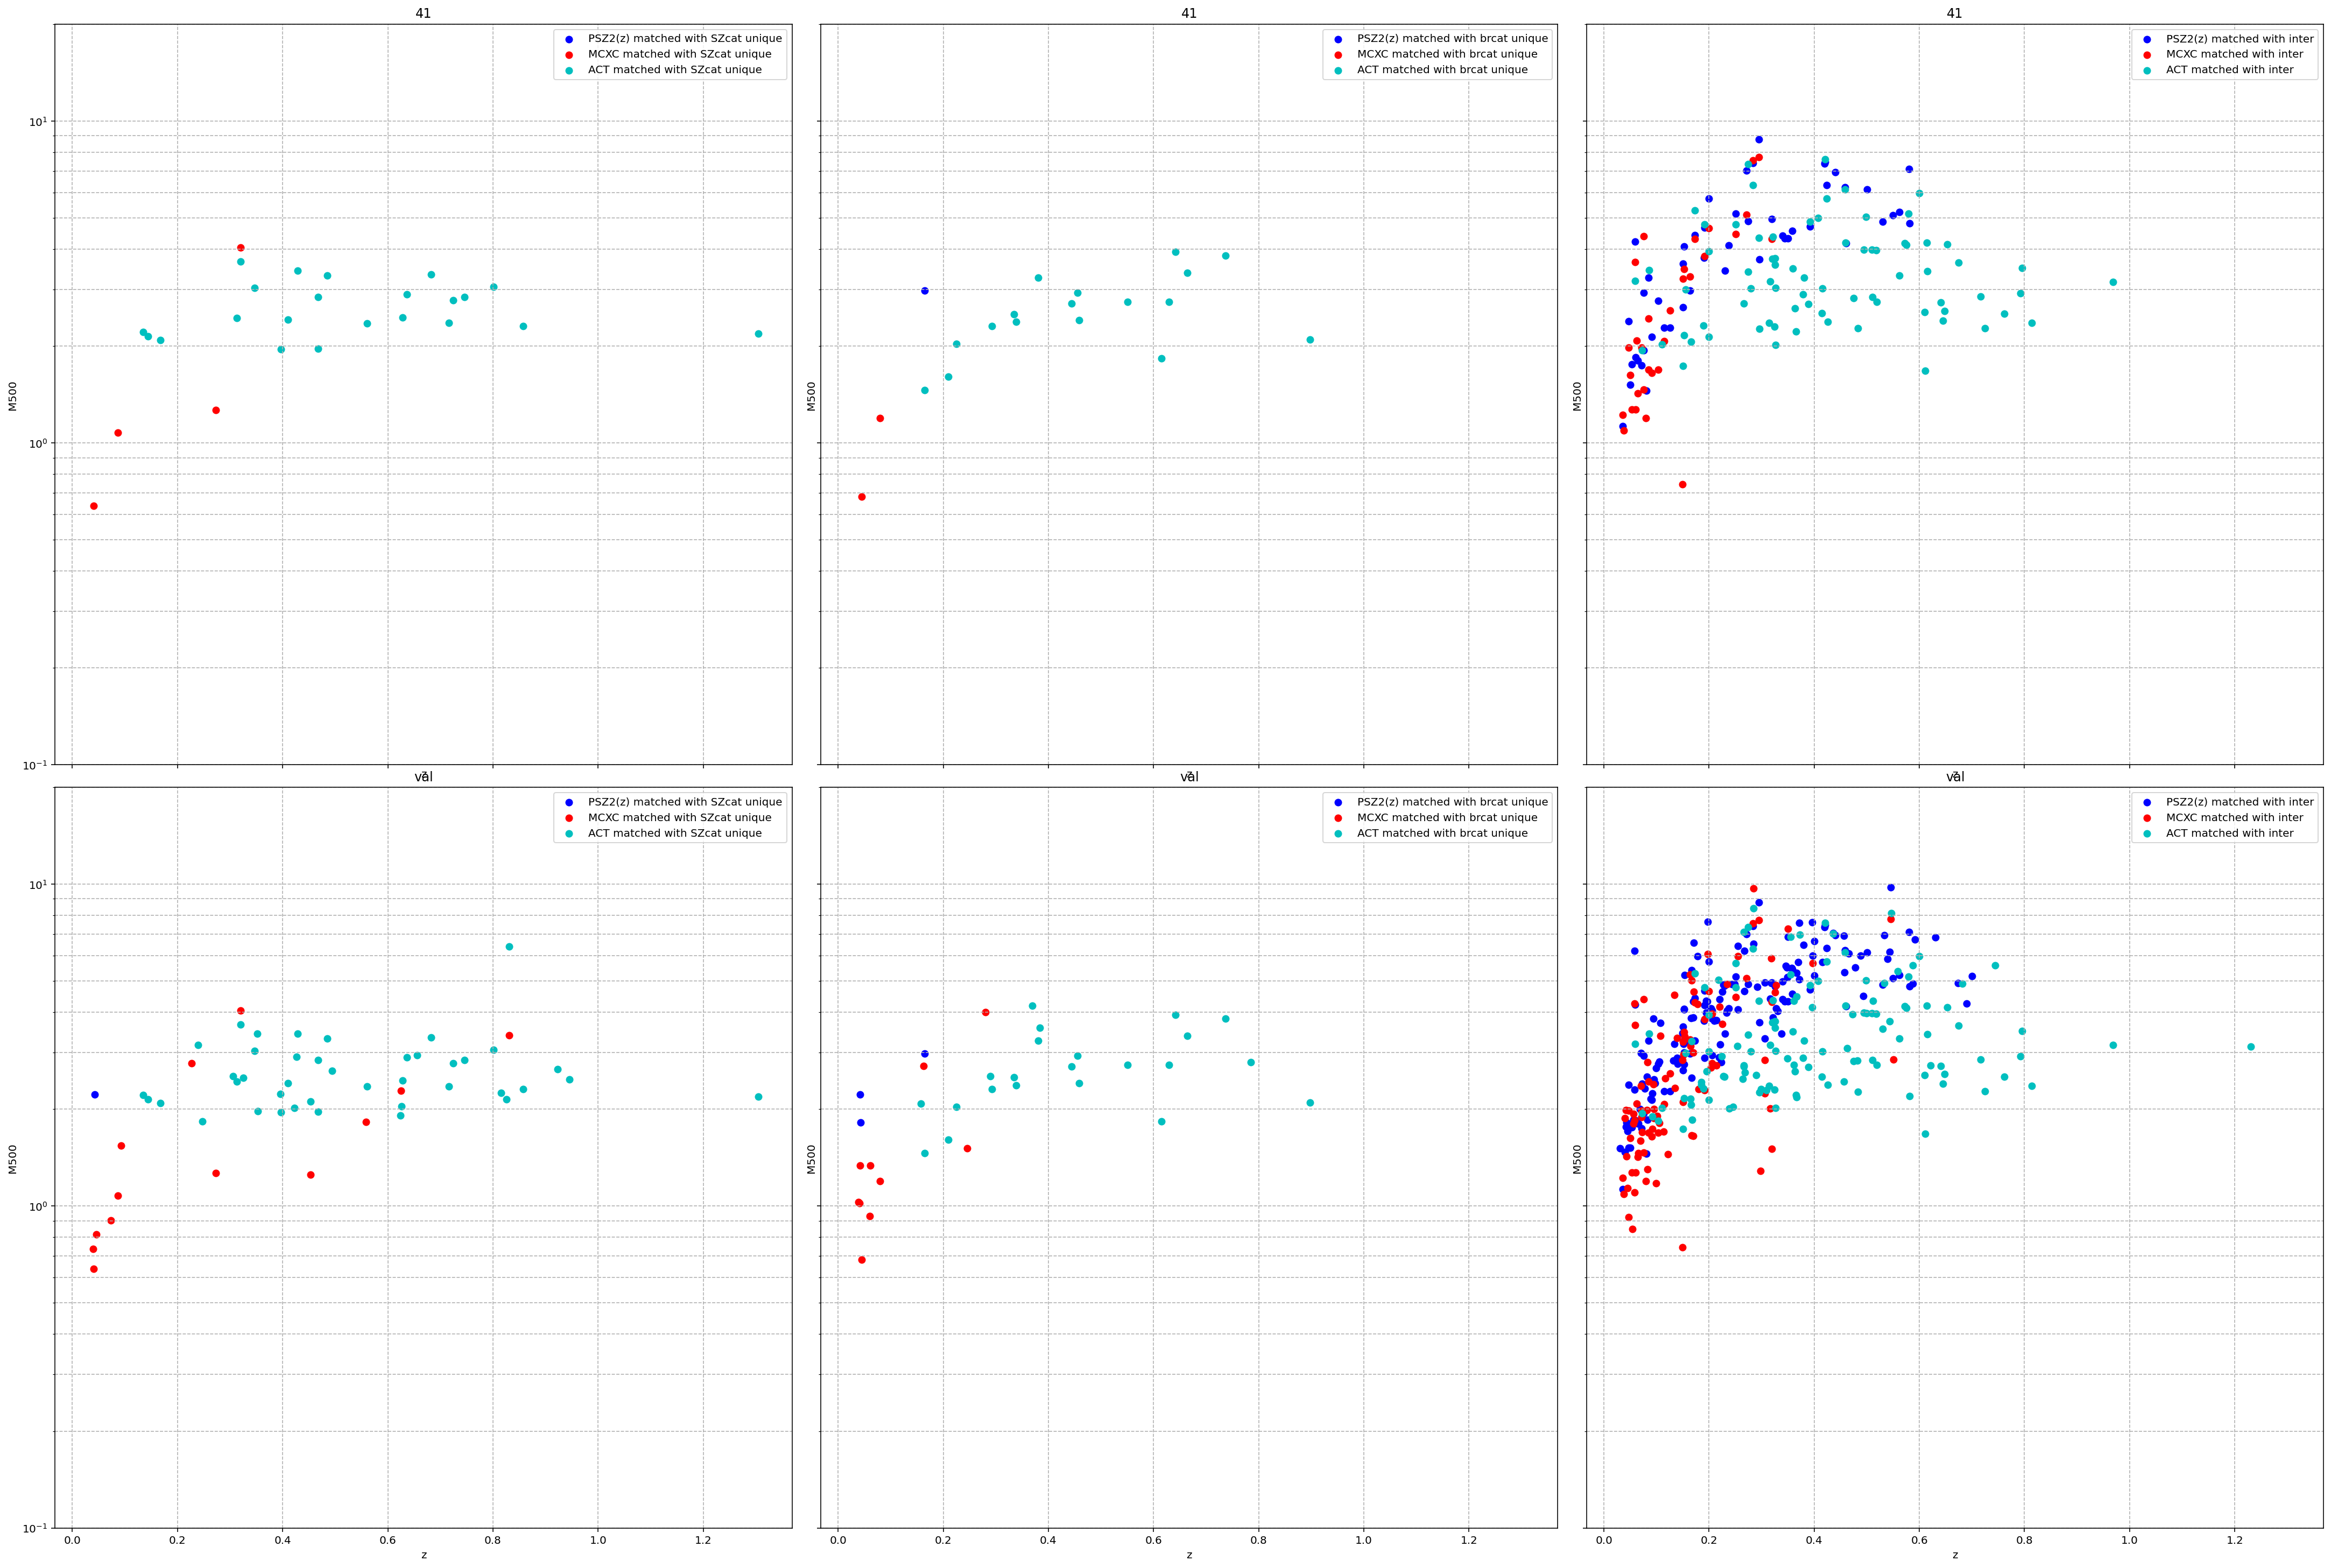

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20), sharey=True, sharex=True)
fig.tight_layout()
m500_z_simple(ax[0][0], '/home/rt2122/Data/inter_cats/all_found_unique.csv', 'SZcat unique', big_pix=[41], text='41')
m500_z_simple(ax[0][1], '/home/rt2122/Data/inter_cats/brcat_unique.csv', 'brcat unique', big_pix=[41], text='41')
m500_z_simple(ax[0][2], '/home/rt2122/Data/inter_cats/inter.csv', 'inter', big_pix=[41], text='41')
m500_z_simple(ax[1][0], '/home/rt2122/Data/inter_cats/all_found_unique.csv', 'SZcat unique', big_pix=east_val+west_val, text='val')
m500_z_simple(ax[1][1], '/home/rt2122/Data/inter_cats/brcat_unique.csv', 'brcat unique', big_pix=east_val+west_val, text='val')
m500_z_simple(ax[1][2], '/home/rt2122/Data/inter_cats/inter.csv', 'inter', big_pix=east_val+west_val, text='val')

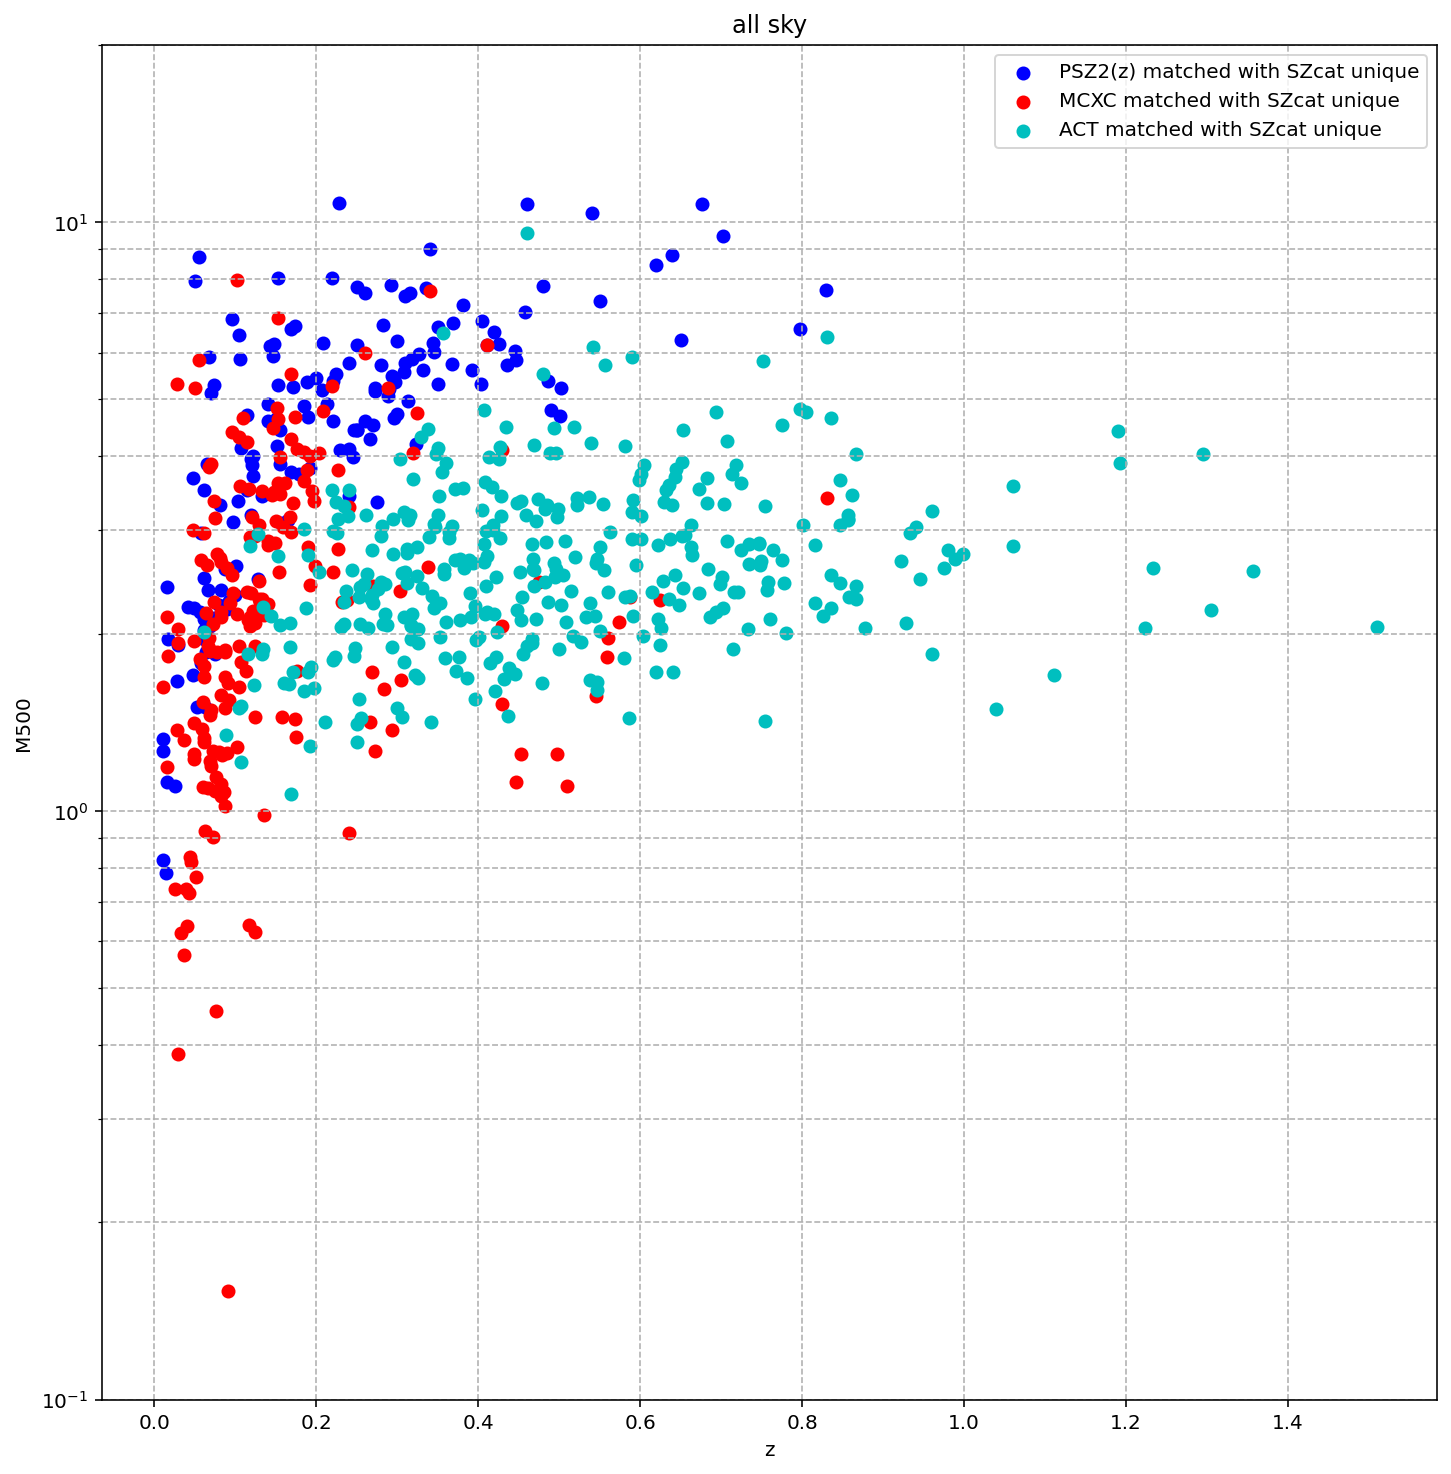

In [27]:
m500_z_simple('/home/rt2122/Data/inter_cats/all_found_unique.csv', 'SZcat unique', big_pix=None, text='all sky')

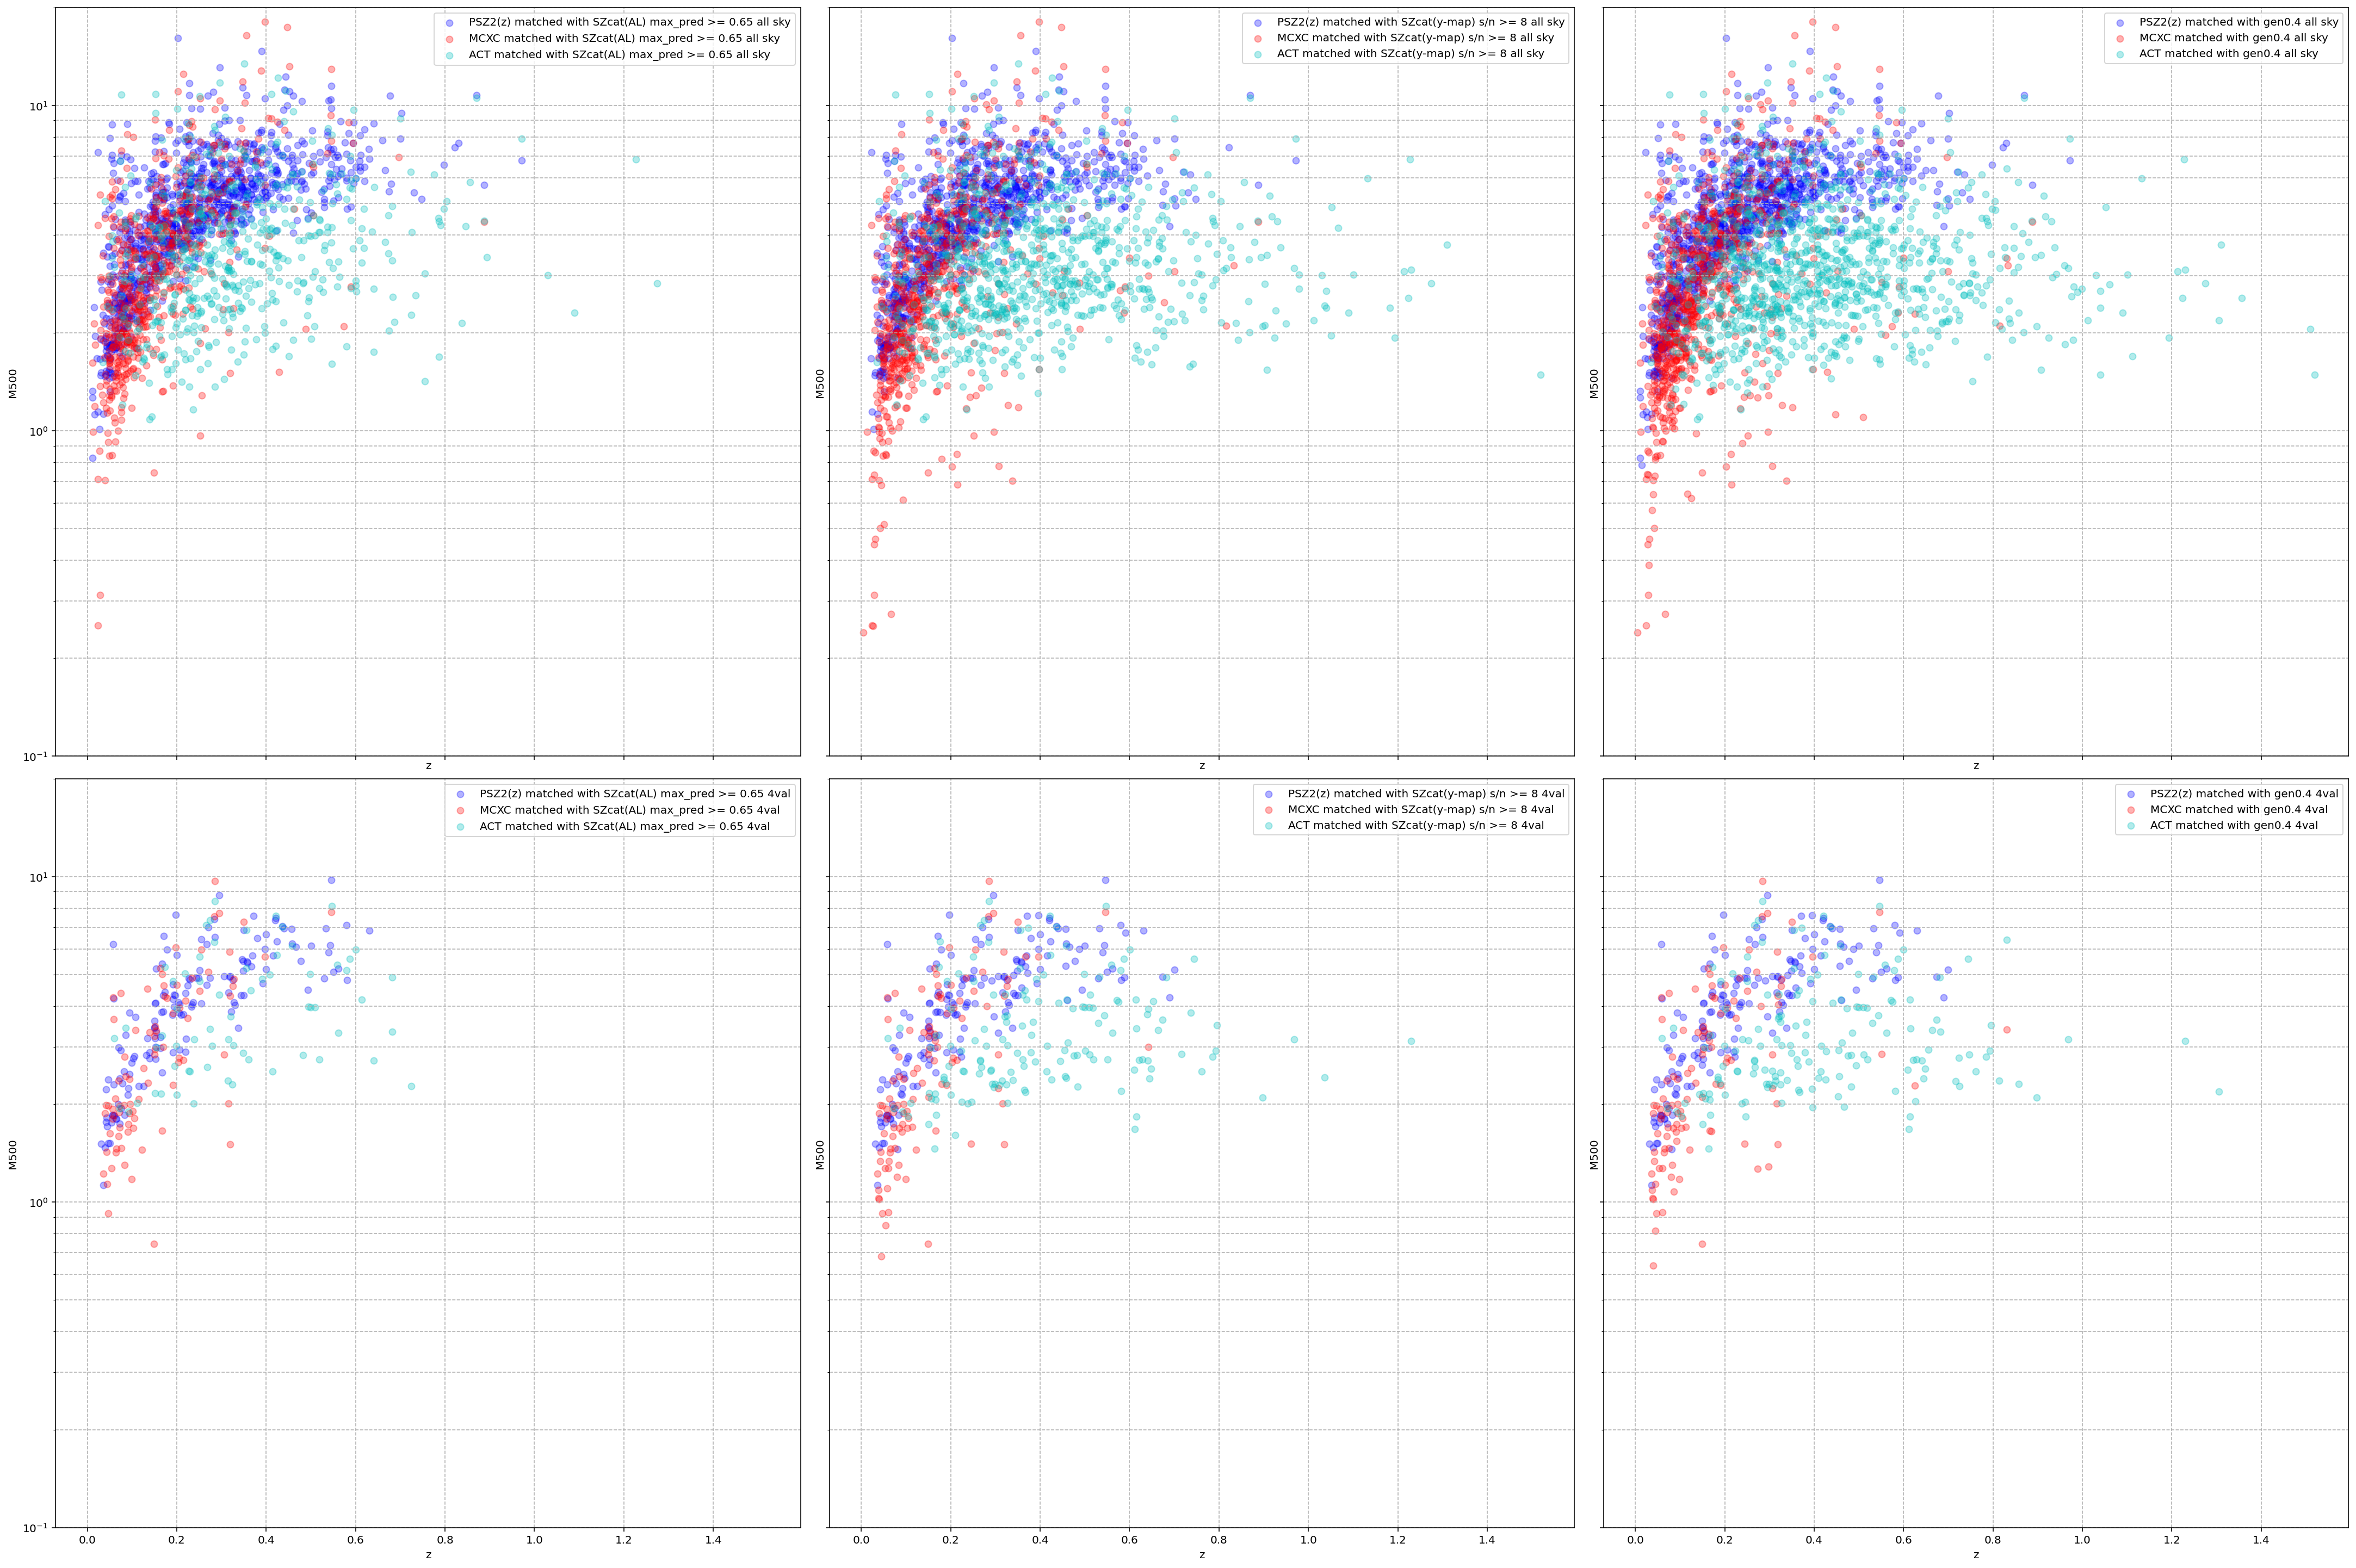

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20), sharey=True, sharex=True)
fig.tight_layout()
names = ['SZcat(AL) max_pred >= 0.65', 
         'SZcat(y-map) s/n >= 8', 
         'gen0.4']
files = ['/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv',
        '/home/rt2122/Data/SRGz/brcat.csv', '/home/rt2122/Data/gen_cats/gen_all_found_brcat_prec0.4.csv']
dicts = [{'max_pred' : [0.65, np.inf]}, {'s/n' : [8, np.inf]}, {}]
pixnames = ['all sky', '4val']
big_pixels = [list(range(48)), west_val + east_val]
for i, (name, file, dict_cut) in enumerate(zip(names, files, dicts)):
    for j, (pixname, big_pix) in enumerate(zip(pixnames, big_pixels)):
        m500_z_simple(ax[j][i], file, name + ' ' + pixname, big_pix=big_pix, text='', alpha=0.3, dict_cut=dict_cut)

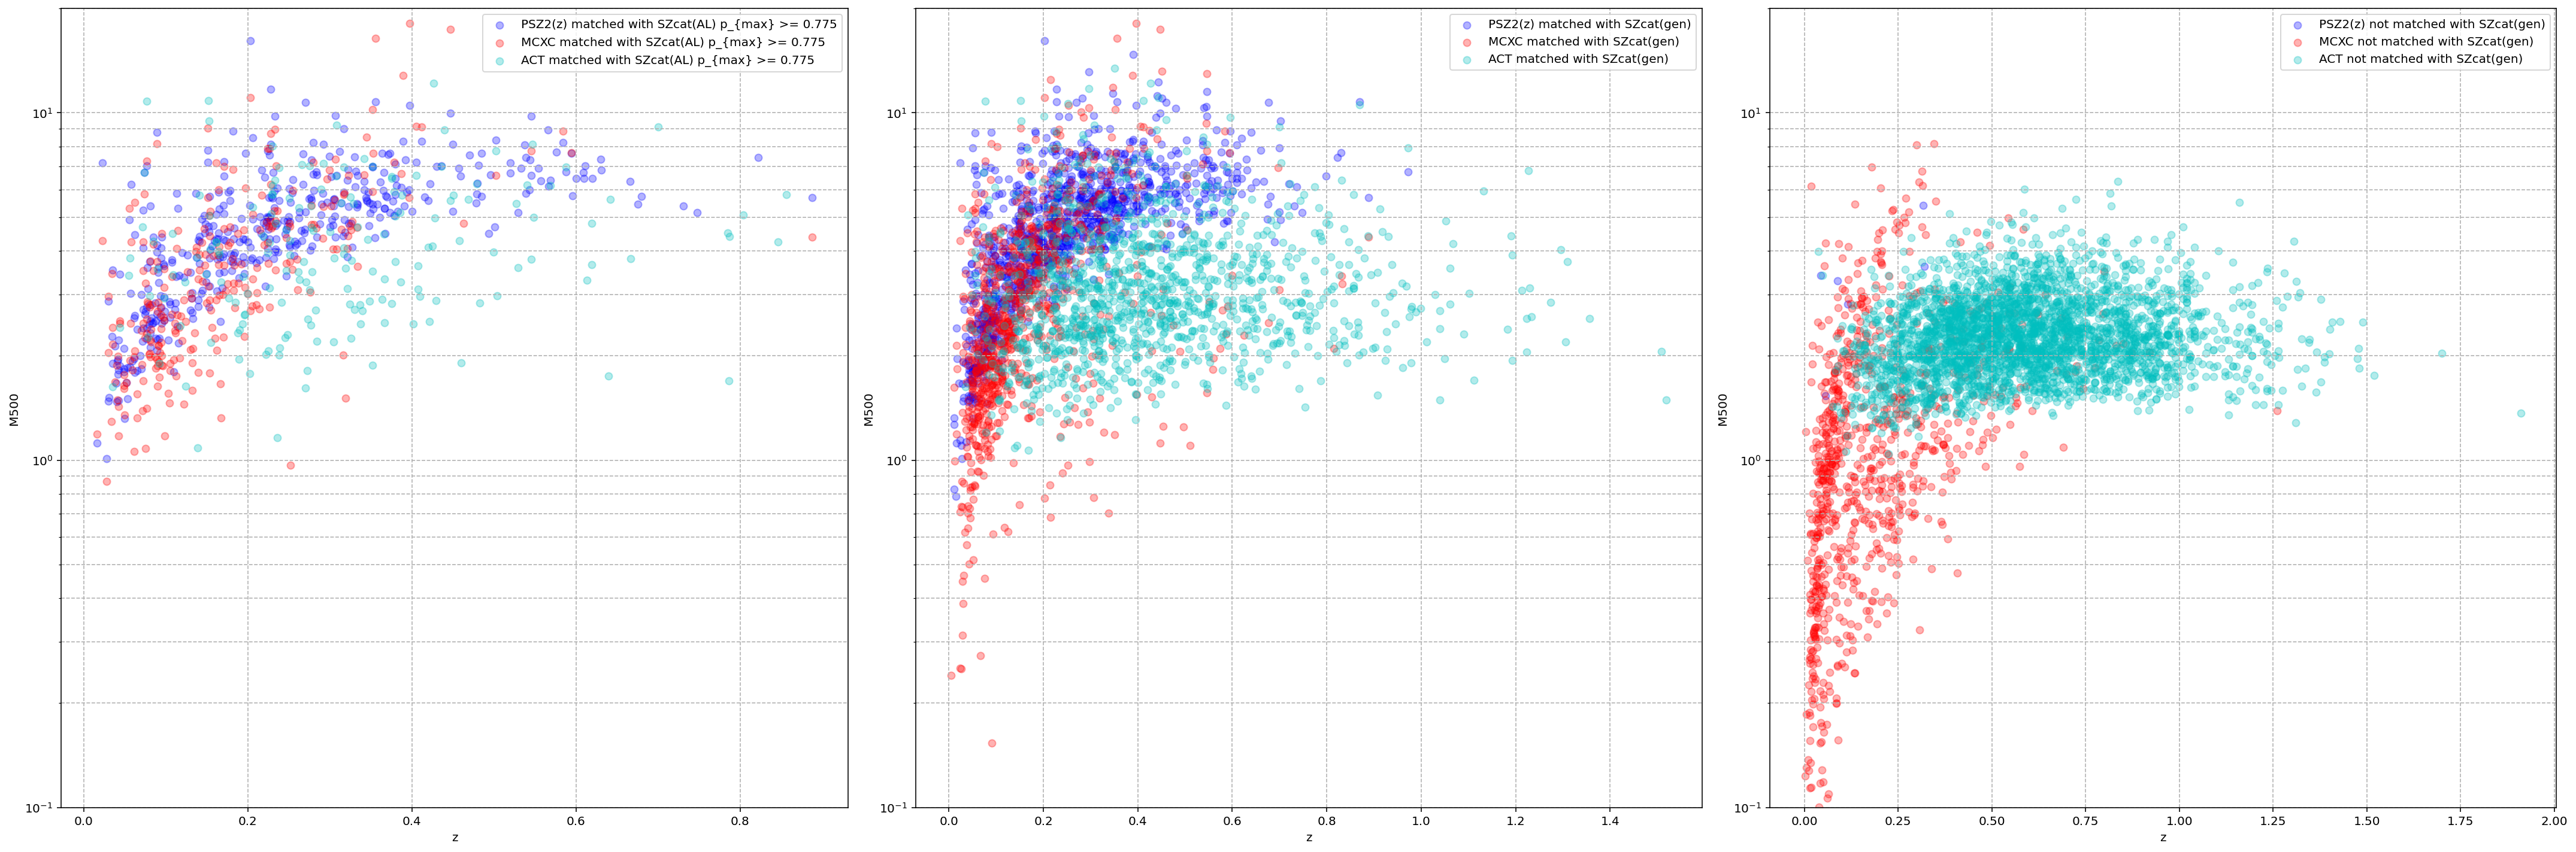

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
alpha=0.3
m500_z_simple(ax[0], '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', 'SZcat(AL) p_{max} >= 0.775', 
              dict_cut={'max_pred' : [0.775, 1.0], 'l' : [0, 180], 'b' : [20, np.inf]}, big_pix=list(range(48)), alpha=alpha)
m500_z_simple(ax[1], '/home/rt2122/Data/gen_cats/gen_all_found_brcat_prec0.00.csv', 'SZcat(gen)', alpha=alpha, ax_unmatched=ax[2],
             dict_cut={'l' : [0, 180], 'b' : [20, np.inf]})
fig.tight_layout()